# I. Algorithm

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [82]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        '''
        Sigmoid function
        '''
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        '''
        Given X training features and corresponding y training features, finds the coefficients that fit the model
        '''
        n_samples, n_features = X.shape
        # Start with zeros for weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Update weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict_probability(self, X):
        '''
        Predicts a probability based on an input X value, considers the weights, bias, and sigmoid function
        '''
        linear_model = np.dot(X, self.weights) + self.bias
        return self.sigmoid(linear_model)

    def predict(self, X):
        '''
        Given probability, predicts a label given X input
        '''
        y_probs = self.predict_probability(X)
        return [1 if prob >= 0.5 else 0 for prob in y_probs]

# II. Application to Data Set

Let's load in our data and create a column for whether or not a coaster has inversions.

In [117]:
coaster_data = pd.read_csv("../coaster_db.csv")

coaster_subset = coaster_data[['height_ft','speed_mph','Inversions_clean','Gforce_clean']]

clean_data = coaster_subset.dropna()

# Creating column for whether coaster has at least one inversion or not

clean_data['Inverted'] = clean_data['Inversions_clean'].apply(lambda x: 1 if x > 0 else 0)

print(f"There are {clean_data.shape[0]} roller coasters we have data for.")
print(f"There are {np.sum(clean_data['Inverted'])} inverted roller coasters.")
print(f"There are {clean_data.shape[0]-np.sum(clean_data['Inverted'])} non-inverted roller coasters.")

There are 70 roller coasters we have data for.
There are 36 inverted roller coasters.
There are 34 non-inverted roller coasters.


/var/folders/xh/x976_5p93059y1sn4ybh8ql40000gn/T/ipykernel_4650/2935719541.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['Inverted'] = clean_data['Inversions_clean'].apply(lambda x: 1 if x > 0 else 0)


Let's look at a correlation heat map to see which features are correlated with each other.

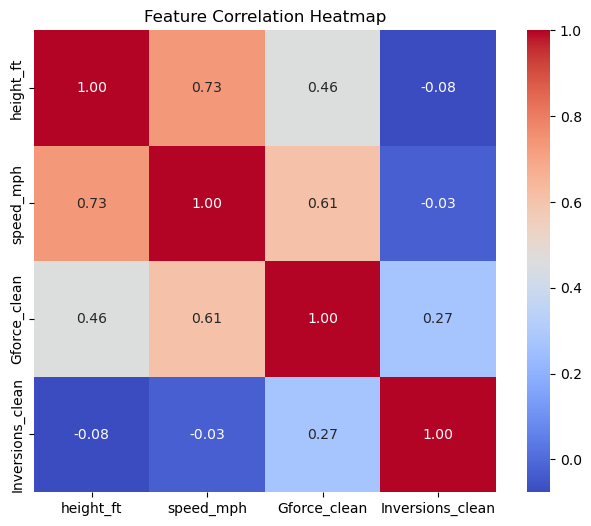

In [122]:
# Compute correlation matrix
corr_matrix = clean_data[['height_ft', 'speed_mph', 'Gforce_clean', 'Inversions_clean']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

We see that height and speed has a moderately high level of correlation. This makes sense given the linear regression model we had just created between these two features in the previous notebook. The other features have a lower correlation level which is good since that means the features will contribute different parts to our model.

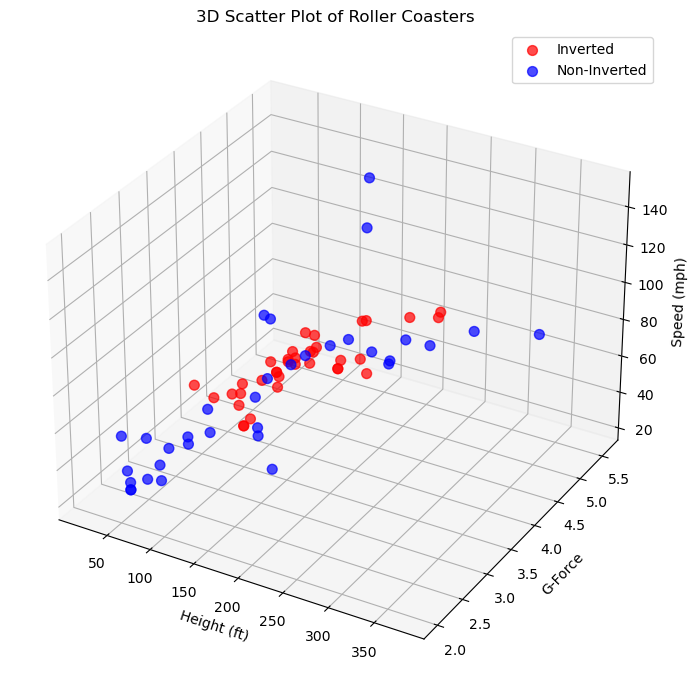

In [123]:
# Split data by inversion status
inverted = clean_data[clean_data['Inverted'] == 1]
non_inverted = clean_data[clean_data['Inverted'] == 0]

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plots
ax.scatter(inverted['height_ft'], inverted['Gforce_clean'], inverted['speed_mph'],
           c='red', label='Inverted', alpha=0.7, s=50)
ax.scatter(non_inverted['height_ft'], non_inverted['Gforce_clean'], non_inverted['speed_mph'],
           c='blue', label='Non-Inverted', alpha=0.7, s=50)

# Axis labels
ax.set_xlabel('Height (ft)')
ax.set_ylabel('G-Force')
ax.set_zlabel('Speed (mph)')
ax.set_title('3D Scatter Plot of Roller Coasters')

ax.legend()
plt.tight_layout()
plt.show()

In [106]:
print("Height")
print(clean_data['height_ft'].describe())
print("Speed")
print(clean_data['speed_mph'].describe())

Height
count     70.000000
mean     126.908571
std       69.676442
min       19.700000
25%       79.275000
50%      109.300000
75%      150.700000
max      377.300000
Name: height_ft, dtype: float64
Speed
count     70.000000
mean      56.742857
std       20.742029
min       22.400000
25%       43.500000
50%       52.800000
75%       66.500000
max      149.100000
Name: speed_mph, dtype: float64


Both speed and height have pretty spread out distributions, as the standard deviations are quite large. Thus, it is helpful for us to standardize our features before applying our model.

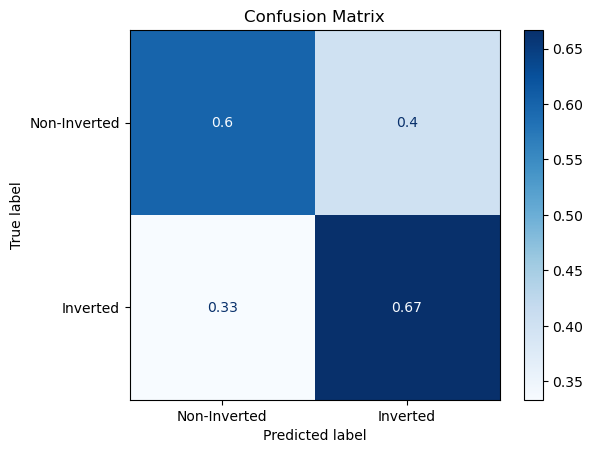

In [120]:
# Preparing training data

X = clean_data[['height_ft','speed_mph','Gforce_clean']].to_numpy()
y = clean_data['Inverted'].to_numpy()

# Scaling Data

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Getting training data

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=32)

# Fitting model

model = LogisticRegression()
model.fit(X_train, y_train)

# Applying model on testing data
y_pred = model.predict(X_test)

# Define your label names 
class_names = ["Non-Inverted", "Inverted"]  

# Plot
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred,
    display_labels=class_names,
    normalize = 'true',
    cmap="Blues"
)
plt.title("Confusion Matrix")
plt.show()


We can see that for non-inverted roller coasters, there's a 60% classification rate. For inverted roller coasters, the correct classification rate is 67%. This is a bit better than guessing 50-50, so ultimately our model could definitley be improved. Logistic regression also applies linear combinations of our features and it seems that our model's underlying relationship is not quite linear.